### ------------------ Module 4b: Machine Learning Analysis ------------------

- What: Train Model and perform analysis
- When: 05 July 2022   

$\color{red}{\text{Define Parameters:}}$

In [66]:
# Path to previously collected data
path='..\\Modules\\Data\\AlgoRun\\'

print('* Path to data:', path)

* Path to data: ..\Modules\Data\AlgoRun\


#### 1. Load some key libaries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

from hurst import compute_Hc, random_walk

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from datetime import date,datetime

# Little function to keep track of code execution.
def Keep_Track():
    print("Executed successfully. " + datetime.now().strftime("%a %d %b @ %H:%M:%S") + "\n")
    
Keep_Track()

Executed successfully. Tue 05 Jul @ 14:34:17



#### 2. Load in a ticker list and the path of previously downloaded data (not currently used)

In [ ]:
# # Load the parameters
# top_mkt = pd.read_csv('TopMarket_Cap.csv')

# # Get the ticket list
# tickers = list(top_mkt.symbol+'USDT')

# print('* Loaded',len(tickers),'tickers.')

# print('')
# Keep_Track()

Take a look

In [ ]:
# top_mkt.head(10)

#### 3. Define various functions create features

In [3]:
print('   - Defining functions -')
print('')

print('* 1. Load data function')
def load_data(tickers,kline_interval,path):
    '''
    Load feather file and return panel data with OHLCV
    '''
    l={}
    for tkrs in tickers:
        try:
            print(os.path.join(path,f'{tkrs}_{kline_interval}.feather'))
            df = pd.read_feather(os.path.join(path,f'{tkrs}_{kline_interval}.feather'))
            df = df.set_index('Open Time')
            l[tkrs]=df
        except:
            print(f'{tkrs} is missing!')
    df_panel = pd.concat(l).swaplevel().sort_index(level=[0,1])
    df_panel.index.set_names('Ticker',1,inplace=True)
    print('')
    print(f'* Total ticker(s) queried {len(tickers)}, total record returned {len(df_panel.index.get_level_values(1).unique())}')
    return df_panel

print('* 2. Current close/avg')
def cal_close_avg(df,w):
    # Current close/avg
    d={}
    for i in w:
        ds = (df.Close/(df.Close.rolling(i).mean()))
        d[f'CurCloseDivAvg_{i}']=ds
    return pd.concat(d,axis=1)

print('* 3. Current volume/avg')
def cal_volume_avg(df,w):
    # Current volume/avg
    d={}
    for i in w:
        ds = (df.Volume/(df.Volume.rolling(i).mean()))
        d[f'CurVolumeDivAvg_{i}']=ds
    return pd.concat(d,axis=1)

print('* 4. Period return up to now')
def cal_bk_return(df,w):
    # Period return up to now
    d={}
    for i in w:
        ds = df.Close.pct_change(i)
        d[f'BackReturn_{i}']=ds
    return pd.concat(d,axis=1)

print('* 5. Period forward return up to w')
def cal_fwd_return(df,w):
    # Period forward return up to w
    d={}
    for i in w:
        ds = df.Close.pct_change(i).shift(-i)
        d[f'FwdReturn_{i}']=ds
    return pd.concat(d,axis=1)

print('* 6. Rolling high/rolling low')
def cal_high_low(df,w):
    #rolling high/rolling low
    d={}
    for i in w:
        ds=df.High.rolling(i).max()/df.Low.rolling(i).min()
        d[f'HighDivLow_{i}']=ds
    return pd.concat(d,axis=1)

print('* 7. Rolling high/rolling mean')
def cal_max_mean(df,w):
    #rolling high/rolling mean
    d={}
    for i in w:
        ds=df.High.rolling(i).max()/df.Close.rolling(i).mean()
        d[f'MaxDivMean_{i}']=ds
    return pd.concat(d,axis=1)

print('* 8. Rolling min/rolling mean')
def cal_min_mean(df,w):
    #rolling min/rolling mean
    d={}
    for i in w:
        ds=df.Low.rolling(i).min()/df.Close.rolling(i).mean()
        d[f'MinDivMean_{i}']=ds
    return pd.concat(d,axis=1)

print('* 9. Rolling high/rolling mean for volume')
def cal_max_mean_volume(df,w):
    #rolling high/rolling mean for volume
    d={}
    for i in w:
        ds=df.Volume.rolling(i).max()/df.Volume.rolling(i).mean()
        d[f'MaxDivMeanVolume_{i}']=ds
    return pd.concat(d,axis=1)

print('* 10. Rolling min/rolling mean for volume')
def cal_min_mean_volume(df,w):
    #rolling min/rolling mean for volume
    d={}
    for i in w:
        ds=df.Volume.rolling(i).min()/df.Volume.rolling(i).mean()
        d[f'MinDivMeanVolume_{i}']=ds
    return pd.concat(d,axis=1)

print('* 11. Rolling std ')
def cal_std(df,w):
    #rolling std 
    d={}
    for i in w:
        ds=df.Close.rolling(i).std()
        d[f'Std_{i}']=ds
    return pd.concat(d,axis=1)

print('* 12. Closing only')
def Closing(df,w):
    #rolling std 
    d={}
    for i in w:
        ds=df.Close.shift(i)
        d[f'Close_{i}']=ds
    
     # Include current by default 
    d[f'Close_{0}'] = df.Close
    return pd.concat(d,axis=1)

print('* 13. Volume only')
def Volume(df,w):
    #rolling std 
    d={}
    for i in w:
        ds=df.Volume.shift(i)
        d[f'Volume_{i}']=ds
        
    # Include current by default     
    d[f'Volume_{0}']=df.Volume   
    return pd.concat(d,axis=1)



print('* 14. Z-score')
def r_zscore(df,w):
    # z_score Tina
    d={}
    for i in w:
        ds=(np.log(df.Volume) - np.log(df.Volume).rolling(i).mean())/np.log(df.Volume).rolling(i).std()
        d[f'Z_Volume_{i}']=ds
         
    return pd.concat(d,axis=1)

print('* 15. Parkinson Vol')
def Parkinson(df,w):
    # z_score Tina
    d={}
    
    for i in w:
        ds = np.log(df.High / df.Low)**2
        d[f'Parkinson_{i}']= 0.5*np.sqrt(ds.rolling(i).sum()) /np.sqrt(np.log(2)*i/(365*1440))
         
    return pd.concat(d,axis=1)

print('* 16. Hurst')
def Hurst(df,w):
    d={}
    Hurst = lambda x: compute_Hc(x, kind='price')[0]
    
    w = [180,360]
    
    for i in w:
        if i>100: # else hurst function fails
            d[f'Hurst{i}']= df.Close.rolling(i).apply(Hurst)
         
    return pd.concat(d,axis=1)


def generate_factors(df_panel,factor_functions,w):
    '''
    generate factors on panel data with rolling window w
    '''
    l=[]
    for f in factor_functions:
        factor = df_panel.groupby('Ticker').apply(f,w)
        l.append(factor)
    return pd.concat(l,axis=1)

print('')
Keep_Track()

   - Defining functions -

* 1. Load data function
* 2. Current close/avg
* 3. Current volume/avg
* 4. Period return up to now
* 5. Period forward return up to w
* 6. Rolling high/rolling low
* 7. Rolling high/rolling mean
* 8. Rolling min/rolling mean
* 9. Rolling high/rolling mean for volume
* 10. Rolling min/rolling mean for volume
* 11. Rolling std 
* 12. Closing only
* 13. Volume only
* 14. Z-score
* 15. Parkinson Vol
* 16. Hurst

Executed successfully. Tue 05 Jul @ 14:34:19



#### 3.1 Function to identify the coin with the max and min correlation for a chosen field

In [4]:
# Correlation analysis across coins for a specific field.
# Example Data = Master, Field = 'FwdReturn_3'

def Correlation_Analysis(Data, Field):
    # Spread the data
    Correl_Data = Master.pivot(index = 'DateTime', columns = 'Ticker', values = Field)

    # Perform the correlation analysis
    Correl_Data = Correl_Data.corr()

    # Set diag to NaN since the function below will skip these (diag is perfectly correlated anyway)
    np.fill_diagonal(Correl_Data.values, np.nan)

    # Create a dataframe for the results
    Results = pd.DataFrame()
    
    # Collect the results.
    Results['Max'] = Correl_Data.idxmax(axis=1)
    Results['Max_Value'] = Correl_Data.max(axis=1)
    Results['Min'] = Correl_Data.idxmin(axis=1)
    Results['Min_Value'] = Correl_Data.min(axis=1)

    # Replace the max value in each row with na and repeat (messy but works)
    Correl_Data = Correl_Data.apply(lambda row: row.replace(np.max(row),np.nan), axis=1)
    Correl_Data = Correl_Data.apply(lambda row: row.replace(np.min(row),np.nan), axis=1)
    Results['Max_2'] = Correl_Data.idxmax(axis=1)
    Results['Max_2_Value'] = Correl_Data.max(axis=1)
    Results['Min_2'] = Correl_Data.idxmin(axis=1)
    Results['Min_2_Value'] = Correl_Data.min(axis=1)
    
    Results = Results.reset_index()
    
    Results['Feature'] = Field
    
    return Results

print('Correlation function defined')

print("")
Keep_Track() 

Correlation function defined

Executed successfully. Tue 05 Jul @ 14:34:27



In [5]:
# Correlation analysis across features for a specific coin.
# For example Data = Master and Coin= 'ADAUSDT'

def Coin_Analysis(Data, Coin):
    
    i=0
    
    # for each feature in the dataset 
    for feature in Master.columns:
        
        if feature == 'DateTime':   
            pass
            
        elif feature == 'Ticker':         
            pass
            
        else:    
            
            # Calculate the correlation
            Correlation_Data = Correlation_Analysis(Data, feature)
            
            if i == 0:
                Results =  Correlation_Data[Correlation_Data['Ticker'] == Coin]
                
            else:
            
                # Filter for the coin
                Results = pd.concat([Results, Correlation_Data[Correlation_Data['Ticker'] == Coin]],ignore_index=True)
        
            i=i+1
        
    return Results    
  
    
print('Correlation analysis function defined')

print("")
Keep_Track()     

Correlation analysis function defined

Executed successfully. Tue 05 Jul @ 14:34:29



In [6]:
# This function calculate the correlations for between features (for example to identify which
# features correlation to the target or to reduce the number of features)

def Correlation_Analysis_Fields(Data):

    # Perform the correlation analysis
    Correl_Data = Data.corr()

    # Set diag to NaN since the function below will skip these (diag is perfectly correlated anyway)
    np.fill_diagonal(Correl_Data.values, np.nan)

    # Create a dataframe for the results
    Results = pd.DataFrame()
    
    # Collect the results.
    Results['Max'] = Correl_Data.idxmax(axis=1)
    Results['Max_Value'] = Correl_Data.max(axis=1)
    Results['Min'] = Correl_Data.idxmin(axis=1)
    Results['Min_Value'] = Correl_Data.min(axis=1)

    # Replace the max value in each row with na and repeat (messy but works)
    Correl_Data = Correl_Data.apply(lambda row: row.replace(np.max(row),np.nan), axis=1)
    Correl_Data = Correl_Data.apply(lambda row: row.replace(np.min(row),np.nan), axis=1)
    Results['Max_2'] = Correl_Data.idxmax(axis=1)
    Results['Max_2_Value'] = Correl_Data.max(axis=1)
    Results['Min_2'] = Correl_Data.idxmin(axis=1)
    Results['Min_2_Value'] = Correl_Data.min(axis=1)
    
    Results = Results.reset_index()
    
#     Results['Feature'] = Field
    
    return Results

print('Feature correlation function defined')

print("")
Keep_Track() 

Feature correlation function defined

Executed successfully. Tue 05 Jul @ 14:34:32



#### 4. Load and process the data from previously generated algo runs)

4.1 Load results from an algo run

In [7]:
# Function to load the data and remove the last few hours of records
def Load_Reduce(Data, Hours):
    Max_Start_Date = np.max(Data['Start_Date'])
    Max_Start_Date = pd.to_datetime(Max_Start_Date, dayfirst=True) - pd.offsets.DateOffset(hours=Hours)
    return Data[Data['Start_Date'] < str(Max_Start_Date)]

Keep_Track()

Executed successfully. Tue 05 Jul @ 14:34:36



In [67]:
# Load the results from the algo run (split up into months to speed calculation)
# The max maturity eas set to 3hrs so we remove the last 3hrs of records from each month (since these will have terminated
# for not applicable reasons)

# The max length of the algo - so we remove records prior to this date to keep the data clean. 
HRS = 3

print('* Loading algo data')
df_panel_1 = pd.read_csv(path+'BTC_Results_1.csv')
df_panel_1 = Load_Reduce(df_panel_1, HRS)

df_panel_2 = pd.read_csv(path+'BTC_Results_2.csv')
df_panel_2 = Load_Reduce(df_panel_2, HRS)

df_panel_3 = pd.read_csv(path+'BTC_Results_3.csv')
df_panel_3 = Load_Reduce(df_panel_3, HRS)

df_panel_4 = pd.read_csv(path+'BTC_Results_4.csv')
df_panel_4 = Load_Reduce(df_panel_4, HRS)

df_panel_5 = pd.read_csv(path+'BTC_Results_5.csv')
df_panel_5 = Load_Reduce(df_panel_5, HRS)

df_panel_6 = pd.read_csv(path+'BTC_Results_6.csv')
df_panel_6 = Load_Reduce(df_panel_6, HRS)

df_panel_7 = pd.read_csv(path+'BTC_Results_7.csv')
df_panel_7 = Load_Reduce(df_panel_7, HRS)

df_panel_8 = pd.read_csv(path+'BTC_Results_8.csv')
df_panel_8 = Load_Reduce(df_panel_8, HRS)

df_panel_9 = pd.read_csv(path+'BTC_Results_9.csv')
df_panel_9 = Load_Reduce(df_panel_9, HRS)

df_panel_10 = pd.read_csv(path+'BTC_Results_10.csv')
df_panel_10 = Load_Reduce(df_panel_10, HRS)

df_panel_11 = pd.read_csv(path+'BTC_Results_11.csv')
df_panel_11 = Load_Reduce(df_panel_11, HRS)

df_panel_12 = pd.read_csv(path+'BTC_Results_12.csv')
df_panel_12 = Load_Reduce(df_panel_12, HRS)

# Concatenate the data
df_panel = pd.concat([df_panel_1, df_panel_2,df_panel_3,df_panel_4,df_panel_5,df_panel_6, 
                      df_panel_7,df_panel_8,df_panel_9,df_panel_10,df_panel_11,df_panel_12])

# Add in a ticker to identify the coin (potentially useful to reuse code)
df_panel['Ticker'] = 'BTC'

# Relabel (useful to reuse code)
df_panel = df_panel.rename(columns = {'Start_Date':'DateTime', 'open_price':'Open', 'close_price':'Close','high_price':'High', 'low_price':'Low'})

print('* Records loaded: ', len(df_panel))
print('* Min date      : ', np.min(df_panel['DateTime']))
print('* Max date      : ', np.max(df_panel['DateTime']))

# Define the dataframe index
df_panel = df_panel.set_index(['DateTime','Ticker'])



print('')
Keep_Track()

* Loading algo data
* Records loaded:  523038
* Min date      :  2021-06-01 00:00:00
* Max date      :  2022-05-31 20:58:00

Executed successfully. Tue 05 Jul @ 15:15:53



Example / Sample

In [9]:
Core_Data = df_panel.reset_index()
Start_Date = '2021-12-01 00:00:00'
Core_Data[Core_Data['DateTime']==Start_Date][['DateTime','End_Date','Life(s)','Initial_Open','Final_Close', 'Level', 'Capital','Cap_Return%']]

,DateTime,End_Date,Life(s),Initial_Open,Final_Close,Level,Capital,Cap_Return%
0,2021-12-01 00:00:00,2021-12-01 00:07:00,420.0,56950.56,57159.53,1,2.78,0.017194


4.2 Plot a Histogram to see distribution of data

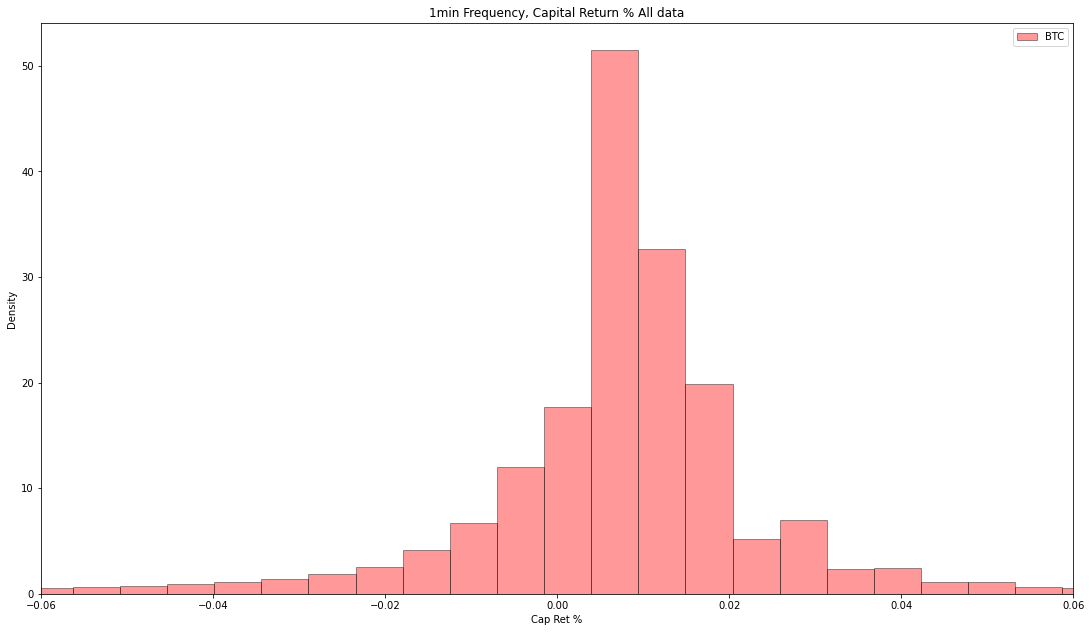

In [10]:
# Setup the bins and min/max of plot.
max_range = 0.06
min_range = -0.06

# setting up the axes
fig, axs = plt.subplots(1, 1, sharey='all', sharex='all')
fig.set_size_inches(18.5, 10.5)

# Create the plot
axs.set_title('1min Frequency, Capital Return % All data')
axs.set_ylabel('Density')
axs.set_xlabel('Cap Ret %')
axs.hist(df_panel['Cap_Return%'], 2000, alpha = 0.4, density=True, color = "red", ec = 'black', lw = 1, label = 'BTC')
axs.legend(loc='upper right')
axs.set_xlim([min_range,max_range]) 

plt.show()

4.3 Calculate selected features for the loaded data

In [11]:
# Define the lag, the panel data and the features of interest

def Calculate_Features_Panel(Panel, factor_functions, Lag, Threshold):
    
    # Register functions in the list for batch processing
    print('* Calculating features.')
#     factor_functions=[Closing, Volume, cal_close_avg,cal_bk_return,cal_high_low,cal_max_mean,cal_min_mean,
#                       cal_volume_avg,cal_max_mean_volume,cal_min_mean_volume,cal_std, r_zscore, Parkinson]

#     factor_functions=[Parkinson, cal_min_mean]
#     factor_functions=[cal_min_mean]

    # Calculate all factors
    # factors = generate_factors(df_panel,factor_functions,w=[2,5,10])
#     factors = generate_factors(Panel,factor_functions,w=Lag)
#     factors = generate_factors(Panel,factor_functions,w=[60, 180])

    
    factors = generate_factors(Panel,factor_functions,Lag)
    
    print(f'* Total features generated: {len(factor_functions)}')
    
    # Reset the index
    factors = factors.reset_index()
    
    # generate target Y, the timeseries needs to be shift by rolling window w for prediction
    print('* Calculate target data.')

    fwd_return = Panel[['Cap_Return%']]
    fwd_return = fwd_return.reset_index()
    fwd_return['Cap_Return%'] = np.double(fwd_return['Cap_Return%'] > Threshold)
#     fwd_return['Cap_Return%'] = np.double(fwd_return['Cap_Return%'] > 0.009)


    print('* Creating master dataframe')
    # Master = pd.merge(factors, fwd_return_rank, how = 'left', left_on = ['DateTime', 'Ticker'], right_on = ['DateTime', 'Ticker'])
    Master = pd.merge(factors, fwd_return, how = 'left', left_on = ['DateTime', 'Ticker'], right_on = ['DateTime', 'Ticker'])

    Start_length = len(Master)

    # Remove all missing values (interpolation could be applied).
    print('* Dropping missing values')
    Master = Master.dropna()
    print('* There were',Start_length-len(Master), 'records removed')

    print('* Max Date:', Master['DateTime'].max())
    print('* Min Date:', Master['DateTime'].min())
    
    print('* Threshold:', Threshold)
    print('* Skew     :', np.sum(fwd_return['Cap_Return%'])/len(fwd_return['Cap_Return%']))

    return Master

print('')
Keep_Track()


Executed successfully. Tue 05 Jul @ 14:34:56



4.4 Calculate the lag features
- Note: Hurst calculation is very slow

In [12]:
# Define the key inputs 

# Code for stress testing to determine importance correlations
# Lag_Data = np.array([(i+1) for i in range(500)])
# Lag_Data = Lag_Data[Lag_Data > 100]

# Lag_Data = [180]
# factor_functions=[Hurst]

Lag_Data = [60,180]
factor_functions=[Closing, Volume, cal_close_avg,cal_bk_return,cal_high_low,cal_max_mean,cal_min_mean,
                  cal_volume_avg,cal_max_mean_volume,cal_min_mean_volume,cal_std, r_zscore, Parkinson]

# Define the threshold
Threshold = 0.009

# Run the caalculation
Master = Calculate_Features_Panel(df_panel,factor_functions, Lag_Data, Threshold)

print('')
Keep_Track()

* Calculating features.
* Total features generated: 13
* Calculate target data.
* Creating master dataframe
* Dropping missing values
* There were 360 records removed
* Max Date: 2022-05-31 20:58:00
* Min Date: 2021-06-01 00:00:00
* Threshold: 0.009
* Skew     : 0.47880842309736577

Executed successfully. Tue 05 Jul @ 14:35:21



In [13]:
# Check.
# Master.info()

4.2 Function to filter data by date

In [14]:
# Create a function to extract data between specific dates.
# Data      : Input data
# UpperDate : Upper date to filter to
# LowerDate : Lower date to filter to

# Output:  Dataframe
# Example Sample_Data(All_Data, 'date-0', UpperDate = '2020-01-01') -- collects all date upto 2020-01-01

def Sample_Data(Data, Field, UpperDate = -1, LowerDate = -1):
    
    # If no upper date is defined
    if UpperDate == -1:
        return Data[(Data[Field] >= LowerDate)].sort_values(by=[Field])
     
    # If no lower date is not define    
    if LowerDate == -1:
        return Data[(Data[Field] < UpperDate)].sort_values(by=[Field])
    
    return Data[(Data[Field] < UpperDate) & (Data[Field] >= LowerDate)].sort_values(by=[Field])

print('* Sample data function created.')
print('')
Keep_Track()

* Sample data function created.

Executed successfully. Tue 05 Jul @ 14:35:34



In [15]:
# Function to calculate correlations at a month level when we are studying one variable with multiple lags only/

def Month_Analysis(Data, Dates):

    Results = pd.DataFrame({'Lag':Lag_Data})

    # Filter data
    Date_Lower = -1

    for indx, Date_Upper in enumerate(Dates):
        Sample = Sample_Data(Data, 'DateTime', LowerDate = Date_Lower, UpperDate = Date_Upper)
        Date_Lower = Date_Upper

        # Compute correlation
        Correlations = Sample.corr()
        Correlations = Correlations.reset_index()
        Results[indx] = Correlations['Cap_Return%']

    Correlations = Master.corr()
    Correlations = Correlations.reset_index()
    Results['All'] = Correlations['Cap_Return%']
    
    return Results

print('')
Keep_Track()



Executed successfully. Tue 05 Jul @ 14:35:37



4.3 Apply the function above to compute monthly correlations

In [16]:
# Define a ist of dates (to define the months/period of interest)
Dates_Interest = ['2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01']

# Generate the results
Results = Month_Analysis(Master, Dates_Interest)

print('')
Keep_Track()


Executed successfully. Tue 05 Jul @ 14:35:42



Plot the results (when stressing the lag - otherwise does not make sense)

In [ ]:
# Create scatter plot of the results

# setting up the axes
fig, axs = plt.subplots(1, 1, sharey='all', sharex='all')
fig.set_size_inches(18.5, 10.5)

# # set up a range of points to calculate the inverse
# x = np.linspace(min_range, max_range, num=300)

# Create the plot
axs.set_title('MinDivMean')
axs.set_ylabel('Correlation')
axs.set_xlabel('Lag')

axs.scatter(Results['Lag'],Results[0], s = 3, label = '0')
axs.scatter(Results['Lag'],Results[1], s = 3, label = '1')
axs.scatter(Results['Lag'],Results[2], s = 3, label = '2')
axs.scatter(Results['Lag'],Results[3], s = 3, label = '3')
axs.scatter(Results['Lag'],Results[4], s = 3, label = '4')
axs.scatter(Results['Lag'],Results['All'], s = 3, label = 'All')

axs.legend(loc='upper right')
# axs.set_xlim([-0.005,0.005]) 
# axs.set_ylim([0,2]) 

plt.show()

#### Select Dataset/coins for analysis

In [17]:
# This function prepares the dataset, it allows additional flexibility to add features of other coins to the modelling

# Examples
# Coins = ['ADAUSDT','ETHUSDT']
# Forecast = FwdReturn_3
# Primary_Coin = 'ADAUSDT'

def Select_coins_Data(Data, Primary_Coin, Coins, Forecast):

    # Select coins
    Coins_Modelling = Data[Data['Ticker'].isin(Coins)]

    # Pivot the data
    Coins_Modelling = Coins_Modelling.pivot(index = 'DateTime', columns = 'Ticker')

    # Re-label the fields
    Coins_Modelling.columns = Coins_Modelling.columns.to_series().str.join('_')

    # Reset the index
    Coins_Modelling = Coins_Modelling.reset_index()

    # Remove the additional coins' feature (future looking)
    for Coin in Coins:
        # Keep this one
        if (Coin == Primary_Coin):
            pass
        else:
            Coins_Modelling = Coins_Modelling.drop(columns = Forecast+'_'+Coin)
    
    return Coins_Modelling

print('')
Keep_Track()


Executed successfully. Tue 05 Jul @ 14:35:48



Apply above function

In [18]:
Primary_Coin = 'BTC'
Coins = ['BTC']
Forecast = 'Cap_Return%'

Coins_Modelling = Select_coins_Data(Master, Primary_Coin, Coins, Forecast)

Keep_Track()

Executed successfully. Tue 05 Jul @ 14:35:51



In [ ]:
Coins_Modelling.head(5)

#### 5 Machine learning

5.1 Train/Test Split

In [19]:
# Function to collect our train and test data
# Data split is as follows
# Start ..... Mid ..... End
#       Train      Test   
def Train_Test_Build(Data, Coin, Forecast_Field, Start, Mid, End):

    
    print('* Train / Test split with ~')
    print('         - Forecast field:',Forecast_Field)
    print('         - Coin          :',Coin)
    Forecast_Field = Forecast_Field + '_' +Coin
    print('         -               :',Forecast_Field)
    print('         - Training      :',Start,"->", Mid)
    print('         - Testing       :',Mid,"->", End)
    print('')

    # Filter by date to create train and test sets
    Train = Sample_Data(Data, 'DateTime', LowerDate = Start, UpperDate = Mid).drop(columns = ['DateTime'])
    Test = Sample_Data(Data, 'DateTime', LowerDate = Mid, UpperDate = End).drop(columns = ['DateTime'])

    TrainX = Train.drop(columns = [Forecast_Field])
    TestX = Test.drop(columns = [Forecast_Field])          
    TrainY = Train[[Forecast_Field]]
    TestY = Test[[Forecast_Field]]

    # summarise the % split
    print("* Test Length   :", len(TestY[Forecast_Field]))
    print("* Train Length  :", len(TrainY[Forecast_Field]))

    # Convert to numpy arrays
    TrainX =TrainX.values
    TrainY = TrainY.values.ravel()

    TestX = TestX.values
    TestY = TestY.values.ravel()

    print('* X shape       :', np.shape(TrainX))
    print('* Y shape       :', np.shape(TrainY))
    
    print('Train Skew      : ',np.sum(TrainY)/len(TrainY))
    print('Test Skew       : ',np.sum(TestY)/len(TestY))
    
    return Train, TrainX, TrainY, Test, TestX, TestY

print("")
Keep_Track()


Executed successfully. Tue 05 Jul @ 14:35:57



Function to returns some simple metrics

In [20]:
def Metrics(Mat):
    
    P = Mat[1,1] / (Mat[0,1]+Mat[1,1])
    R = Mat[1,1] / (Mat[1,0]+Mat[1,1])
    
    print('  - Accuracy :',round((Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]),3))
    print('  - Precision:',round(P,3))
    print('  - Recall   :',round(R,3))
    print('  - F1       :',round(2*P*R/(P+R),3))
    
    
print("")
Keep_Track()


Executed successfully. Tue 05 Jul @ 14:36:00



Determine Train and Test groups

In [21]:
Forecast_Field = 'Cap_Return%'
Coin = 'BTC'

Start = '2021-08-01'
Mid = '2022-02-01'
End = '2022-03-01'

Train, TrainX, TrainY, Test, TestX, TestY = Train_Test_Build(Coins_Modelling, Coin, Forecast_Field, Start,  Mid, End)

print("")
Keep_Track()

* Train / Test split with ~
         - Forecast field: Cap_Return%
         - Coin          : BTC
         -               : Cap_Return%_BTC
         - Training      : 2021-08-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-03-01

* Test Length   : 40139
* Train Length  : 263304
* X shape       : (263304, 28)
* Y shape       : (263304,)
Train Skew      :  0.4686028317078358
Test Skew       :  0.4816014350133287

Executed successfully. Tue 05 Jul @ 14:36:13



5.3 Train the model

In [22]:
# Select the model choice

Model = 'RF'
# Model = 'Boost'

if Model == 'RF':
    print("* Training Random Forest")
    print('')
    Model = RandomForestClassifier(max_depth= 6, random_state=4021, n_estimators = 60)

if Model == 'Boost':
    print("* Training Gradient Boosting")
    print('')
    Model = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)


Model.fit(TrainX, TrainY)

print("Model trained")
print("-------------")
# print("Estimators :", Estimators)
print("Features   :", Model.n_features_in_)
#print("OOB        :", Model.oob_score_)

# Generate some forecasts
ForecastsTrainY = Model.predict(TrainX)
ForecastsY = Model.predict(TestX)

Mat = confusion_matrix(TestY, ForecastsY)
print('')
print('* Testing set')
Metrics(Mat)

Mat = confusion_matrix(TrainY, ForecastsTrainY)
print('')
print('* Training set')
Metrics(Mat)

print("")
Keep_Track()

* Training Random Forest

Model trained
-------------
Features   : 28

* Testing set
  - Accuracy : 0.608
  - Precision: 0.62
  - Recall   : 0.481
  - F1       : 0.542

* Training set
  - Accuracy : 0.62
  - Precision: 0.642
  - Recall   : 0.43
  - F1       : 0.515

Executed successfully. Tue 05 Jul @ 14:36:43



5.4 Feature Importance

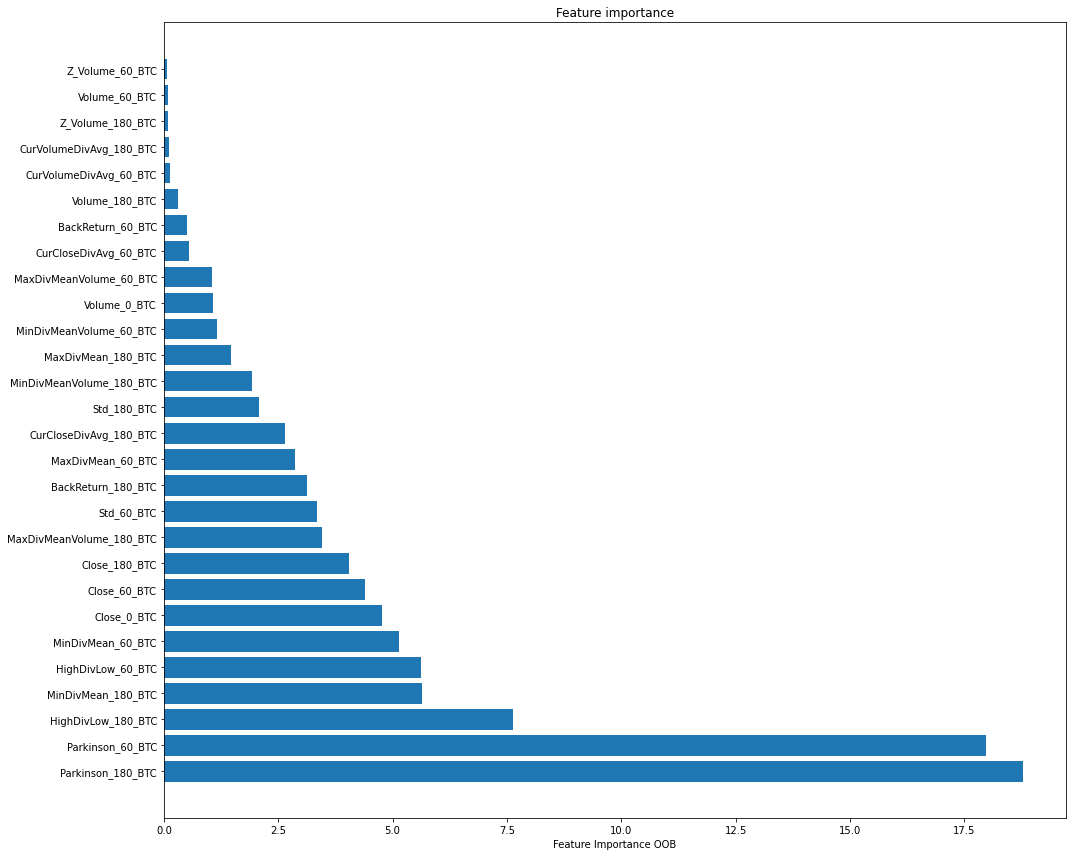

In [23]:
# Out of the box feature importance direct from model
importance = Model.feature_importances_
Important_Fields = pd.DataFrame({'Field': Coins_Modelling.drop(columns = ['DateTime', 'Cap_Return%_BTC']).columns, 'Importance':100*importance}).sort_values(by = ['Importance'], ascending=False)

# Plot a little graph
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(15, 12)

# Horizontal bar chart
ax1.set_title("Feature importance")
ax1.barh(Important_Fields['Field'], Important_Fields['Importance'])
ax1.set_xlabel("Feature Importance OOB")


plt.tight_layout()

In [24]:
# Function to plot the feature importance for a specific model configuration.
def Plot_Importance(Results_Test, Metric, Data):
    
    fig, axs = plt.subplots(1, 1, figsize=(15,10))

    sorted_idx = Results_Test[Metric].importances_mean.argsort()
    axs.boxplot(Results_Test[Metric].importances[sorted_idx].T, vert=False, labels=Data.columns[sorted_idx])
    axs.set_title("Permutation Importances (Test set) "+Metric)


    fig.tight_layout()

    plt.show()

Keep_Track()    

Executed successfully. Tue 05 Jul @ 14:37:01



Permutation importance feature analysis

In [25]:
# Calculate the permutation importance.
result_test = permutation_importance(Model, TestX, TestY, n_repeats=10,
                                random_state=0, scoring=['f1','precision','recall', 'neg_log_loss'])
print("")
Keep_Track()


Executed successfully. Tue 05 Jul @ 14:38:06



Plot a summary of the results

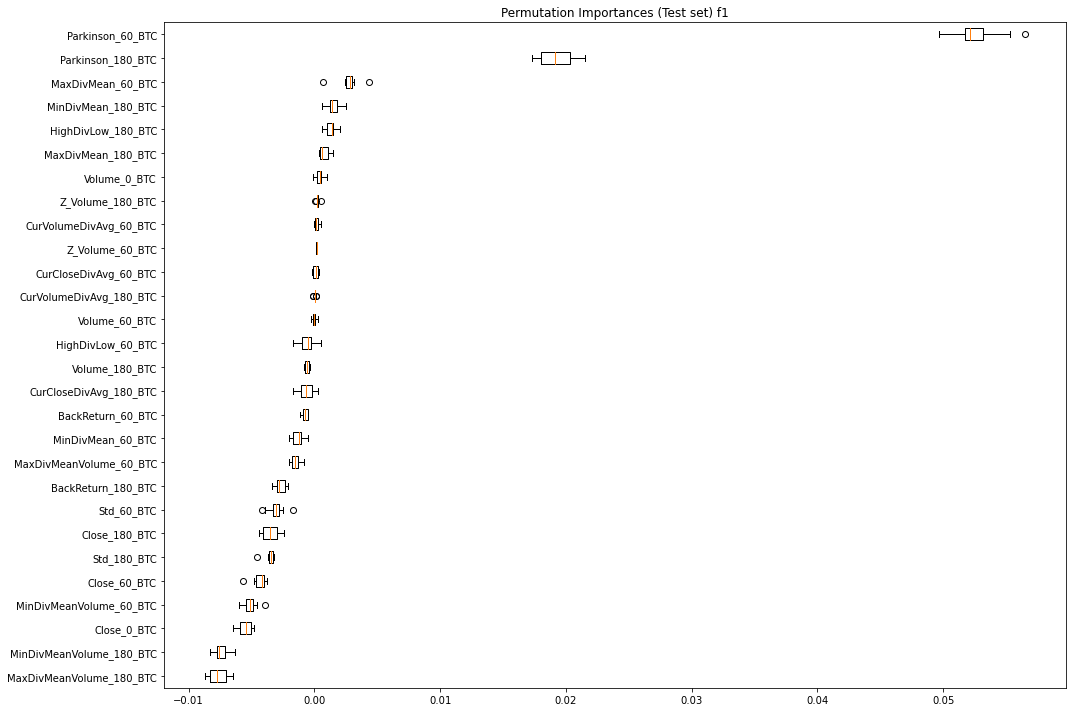

In [26]:
# Box plot for a visualisation of the results.
Plot_Importance(result_test, 'f1', Coins_Modelling.drop(columns = ['DateTime', 'Cap_Return%_BTC']))

In [27]:
# Function to calculate measures over a range of probability thresholds
# This could  be useful to set the thresholds in practice.

def ROC_Bostock(DataX, DataY, step):
    # Compute the model probabilities for the data points.
    Prob = Model.predict_proba(DataX)
    DataY = DataY.astype(bool)
    
    # We need only keep one of the entries (since they sum to 1)
    # Keep the first one
    Prob = Prob[:,1]
    
    TPR = np.empty(0)
    FPR = np.empty(0)
    Prec = np.empty(0)
    F1 = np.empty(0)
    XEnt = np.empty(0)
    
    # Then forecast over a range of thresholds and compare to actuals.
    for T in np.arange(0,1,step):
        Prob_T = Prob>T
        
        # The compute metrics
        R = np.sum(Prob_T & DataY) / np.sum(DataY)
        TPR = np.append(TPR,R)
        FPR = np.append(FPR,np.sum(Prob_T & ~DataY) / (len(DataY) - np.sum(DataY)))
        P = np.sum(Prob_T & DataY) / (np.sum(Prob_T & ~DataY) +np.sum(Prob_T & DataY)) 
        Prec = np.append(Prec, P)
        F1 = np.append(F1, 2*P*R / (R + P))
        #XEnt = np.append(XEnt, -np.sum(Prob_T * np.log(DataY + 0.00000000001)))
    
    return pd.DataFrame({'T': np.arange(0,1,step), 'TPR':TPR, 'FPR': FPR, 'Prec':Prec, 'F1':F1})    

Keep_Track() 

Executed successfully. Tue 05 Jul @ 14:38:28



Calculate the impact of thresholds on the performance

In [28]:
print('* Calculating ROC metrics')
Curve_Test = ROC_Bostock(TestX, TestY, 0.001)
Curve_Train = ROC_Bostock(TrainX, TrainY, 0.001)

print("")
Keep_Track()

* Calculating ROC metrics


C:\Users\pbo44\AppData\Local\Temp/ipykernel_11112/1737635584.py:27: RuntimeWarning: invalid value encountered in long_scalars
  P = np.sum(Prob_T & DataY) / (np.sum(Prob_T & ~DataY) +np.sum(Prob_T & DataY))



Executed successfully. Tue 05 Jul @ 14:38:33



C:\Users\pbo44\AppData\Local\Temp/ipykernel_11112/1737635584.py:27: RuntimeWarning: invalid value encountered in long_scalars
  P = np.sum(Prob_T & DataY) / (np.sum(Prob_T & ~DataY) +np.sum(Prob_T & DataY))


Plot the results of the threshold analysis

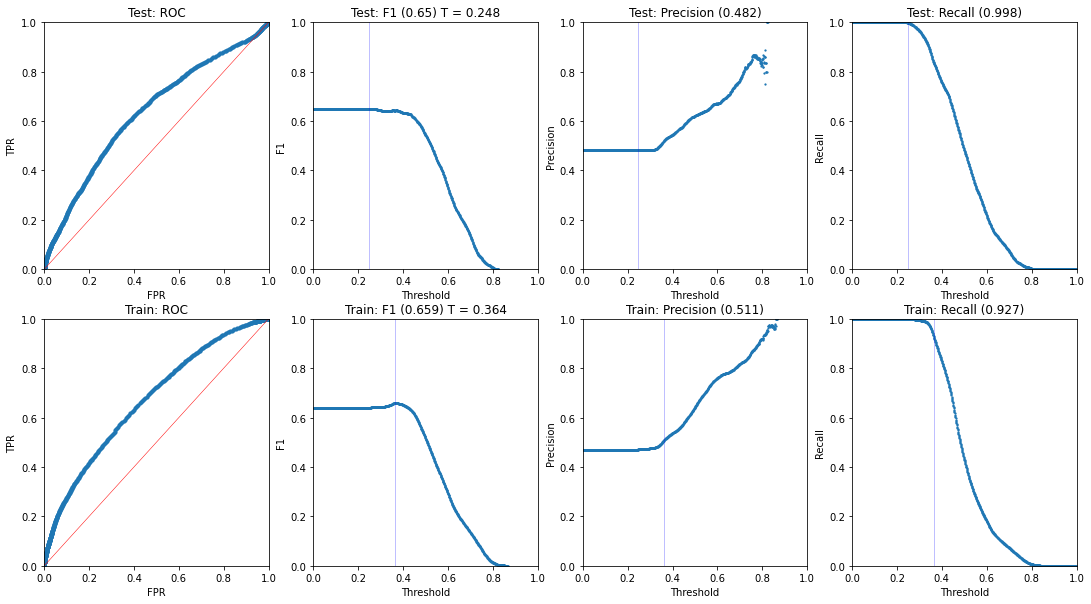

In [29]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18.5, 10)

min_range, max_range = 0.01, 50
x = np.linspace(min_range, max_range, num=100)


Best_T = Curve_Test['T'][np.argmax(Curve_Test['F1'])]
F1 = Curve_Test['F1'][np.argmax(Curve_Test['F1'])]
Precision = Curve_Test['Prec'][np.argmax(Curve_Test['F1'])]
Recall = Curve_Test['TPR'][np.argmax(Curve_Test['F1'])]

Best_T_Train = Curve_Train['T'][np.argmax(Curve_Train['F1'])]
F1_Train = Curve_Train['F1'][np.argmax(Curve_Train['F1'])]
Precision_Train = Curve_Train['Prec'][np.argmax(Curve_Train['F1'])]
Recall_Train = Curve_Train['TPR'][np.argmax(Curve_Train['F1'])]

# Create the  plot
axs[0,0].scatter(Curve_Test['FPR'], Curve_Test['TPR'], s=10)
axs[0,0].axline((0,0),slope = 1, color = 'r', lw = 0.5)
axs[0,0].set_xlabel('FPR')
axs[0,0].set_ylabel('TPR')
axs[0,0].set_title('Test: ROC')
axs[0,0].set_xlim([0,1])
axs[0,0].set_ylim([0,1])

axs[0,1].scatter(Curve_Test['T'], Curve_Test['F1'], s=1.5)
axs[0,1].set_xlabel('Threshold')
axs[0,1].set_ylabel('F1')
axs[0,1].set_title('Test: F1 ('+str(round(F1,3))+') T = ' + str(round(Best_T,3)))
axs[0,1].axvline(x=Best_T, lw = 0.5, alpha = 0.5, color = 'b')
axs[0,1].set_xlim([0,1])
axs[0,1].set_ylim([0,1])

axs[0,2].scatter(Curve_Test['T'], Curve_Test['Prec'], s=1.5)
axs[0,2].axvline(x=Best_T, lw = 0.5, alpha = 0.5, color = 'b')
axs[0,2].set_xlabel('Threshold')
axs[0,2].set_ylabel('Precision')
axs[0,2].set_title('Test: Precision (' + str(round(Precision,3))+')')
axs[0,2].set_xlim([0,1])
axs[0,2].set_ylim([0,1])

axs[0,3].scatter(Curve_Test['T'], Curve_Test['TPR'], s=1.5)
axs[0,3].axvline(x=Best_T, lw = 0.5, alpha = 0.5, color = 'b')
axs[0,3].set_xlabel('Threshold')
axs[0,3].set_ylabel('Recall')
axs[0,3].set_title('Test: Recall (' + str(round(Recall,3))+')')
axs[0,3].set_xlim([0,1])
axs[0,3].set_ylim([0,1])

axs[1,0].scatter(Curve_Train['FPR'], Curve_Train['TPR'], s=10)
axs[1,0].axline((0,0),slope = 1, color = 'r', lw = 0.5)
axs[1,0].set_xlabel('FPR')
axs[1,0].set_ylabel('TPR')
axs[1,0].set_title('Train: ROC')
axs[1,0].set_xlim([0,1])
axs[1,0].set_ylim([0,1])

axs[1,1].scatter(Curve_Train['T'], Curve_Train['F1'], s=1.5)
axs[1,1].axvline(x=Best_T_Train, lw = 0.5, alpha = 0.5, color = 'b')
axs[1,1].set_xlabel('Threshold')
axs[1,1].set_ylabel('F1')
axs[1,1].set_title('Train: F1 (' + str(round(F1_Train,3)) + ') T = ' + str(round(Best_T_Train,3)))
axs[1,1].set_xlim([0,1])
axs[1,1].set_ylim([0,1])

axs[1,2].scatter(Curve_Train['T'], Curve_Train['Prec'], s=1.5)
axs[1,2].axvline(x=Best_T_Train, lw = 0.5, alpha = 0.5, color = 'b')
axs[1,2].set_xlabel('Threshold')
axs[1,2].set_ylabel('Precision')
axs[1,2].set_title('Train: Precision (' + str(round(Precision_Train,3))+')')
axs[1,2].set_xlim([0,1])
axs[1,2].set_ylim([0,1])

axs[1,3].scatter(Curve_Train['T'], Curve_Train['TPR'], s=1.5)
axs[1,3].axvline(x=Best_T_Train, lw = 0.5, alpha = 0.5, color = 'b')
axs[1,3].set_xlabel('Threshold')
axs[1,3].set_ylabel('Recall')
axs[1,3].set_title('Train: Recall (' + str(round(Recall_Train,3))+')')
axs[1,3].set_xlim([0,1])
axs[1,3].set_ylim([0,1])
plt.show()

Roll forward validation

In [30]:
# Construct some key dates for the validation process
# This is ad-hoc to perform some validation
Key_Dates = np.array([])

for i in range(15):
    if i < 4:
        print('2021-0'+str(i+6)+'-01')
        Key_Dates = np.append(Key_Dates, '2021-0'+str(i+6)+'-01')

    elif i < 7:
        print('2021-'+str(i+6)+'-01')
        Key_Dates = np.append(Key_Dates, '2021-'+str(i+6)+'-01')
        
    elif i < 15:
        print('2022-0'+str(i-6)+'-01')
        Key_Dates = np.append(Key_Dates, '2022-0'+str(i-6)+'-01')

print('')
Keep_Track() 

2021-06-01
2021-07-01
2021-08-01
2021-09-01
2021-10-01
2021-11-01
2021-12-01
2022-01-01
2022-02-01
2022-03-01
2022-04-01
2022-05-01
2022-06-01
2022-07-01
2022-08-01

Executed successfully. Tue 05 Jul @ 14:38:39



In [31]:
# Run the model over a rolling window (train 4 months forecast 1 month) then roll forward to next month and re-run
Forecast_Field = 'Cap_Return%'
Coin = 'BTC'


RF_Model = np.array([])
Boost_Model = np.array([])

Train_Skew = np.array([])
Test_Skew = np.array([])

Accuracy_Test_RF,Precision_Test_RF,Recall_Test_RF = np.array([]),np.array([]),np.array([])
Accuracy_Train_RF,Precision_Train_RF,Recall_Train_RF = np.array([]),np.array([]),np.array([])

Accuracy_Test_Boost,Precision_Test_Boost,Recall_Test_Boost = np.array([]),np.array([]),np.array([])
Accuracy_Train_Boost,Precision_Train_Boost,Recall_Train_Boost = np.array([]),np.array([]),np.array([])

for index in range(8):
    print('   Start        Mid          End')
    print(Key_Dates[index],':' ,Key_Dates[index+4],':' ,Key_Dates[index+5])
    Start = Key_Dates[index]
    Mid = Key_Dates[index+4]
    End = Key_Dates[index+5]

    # Train the model
    Train, TrainX, TrainY, Test, TestX, TestY = Train_Test_Build(Coins_Modelling, Coin, Forecast_Field, Start,  Mid, End)

    Train_Skew = np.append(Train_Skew, np.sum(TrainY)/len(TrainY))
    Test_Skew = np.append(Test_Skew, np.sum(TestY)/len(TestY))
    
    print("* Training RF Model")
    Estimators = 60
    Model_RF = RandomForestClassifier(max_depth= 6, random_state=4021, n_estimators = Estimators)
    Model_RF.fit(TrainX, TrainY)

    print("Model trained")
    
    RF_Model = np.append(RF_Model, Model_RF)

    print("* Training Boost Model")
    Model_Boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)
    Model_Boost.fit(TrainX, TrainY)

    print("Model trained")  

    Boost_Model = np.append(Boost_Model, Model_Boost)
    
    # Generate some forecasts
    ForecastsTrainY_RF = Model_RF.predict(TrainX)
    ForecastsY_RF = Model_RF.predict(TestX)
    
    ForecastsTrainY_Boost = Model_Boost.predict(TrainX)
    ForecastsY_Boost = Model_Boost.predict(TestX)
    
    Mat = confusion_matrix(TestY, ForecastsY_RF)
    Accuracy_Test_RF = np.append(Accuracy_Test_RF, (Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]))
    Precision_Test_RF = np.append(Precision_Test_RF, Mat[1,1] / (Mat[0,1]+Mat[1,1]))
    Recall_Test_RF = np.append(Recall_Test_RF, Mat[1,1] / (Mat[1,0]+Mat[1,1]))
    
    print('  - _RF Accuracy  (Test):',round((Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]),3))
    print('  - _RF Precision (Test):',round(Mat[1,1] / (Mat[0,1]+Mat[1,1]),3))
    print('  - _RF Recall    (Test):',round(Mat[1,1] / (Mat[1,0]+Mat[1,1]),3))

    Mat = confusion_matrix(TestY, ForecastsY_Boost)
    Accuracy_Test_Boost = np.append(Accuracy_Test_Boost, (Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]))
    Precision_Test_Boost = np.append(Precision_Test_Boost, Mat[1,1] / (Mat[0,1]+Mat[1,1]))
    Recall_Test_Boost = np.append(Recall_Test_Boost, Mat[1,1] / (Mat[1,0]+Mat[1,1]))
    
    print('  - _Boost Accuracy  (Test):',round((Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]),3))
    print('  - _Boost Precision (Test):',round(Mat[1,1] / (Mat[0,1]+Mat[1,1]),3))
    print('  - _Boost Recall    (Test):',round(Mat[1,1] / (Mat[1,0]+Mat[1,1]),3))    
    
    Mat = confusion_matrix(TrainY, ForecastsTrainY_RF)
    Accuracy_Train_RF = np.append(Accuracy_Train_RF, (Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]))
    Precision_Train_RF = np.append(Precision_Train_RF, Mat[1,1] / (Mat[0,1]+Mat[1,1]))
    Recall_Train_RF = np.append(Recall_Train_RF, Mat[1,1] / (Mat[1,0]+Mat[1,1]))
    
    print('  - _RF Accuracy  (Train):',round((Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]),3))
    print('  - _RF Precision (Train):',round(Mat[1,1] / (Mat[0,1]+Mat[1,1]),3))
    print('  - _RF Recall    (Train):',round(Mat[1,1] / (Mat[1,0]+Mat[1,1]),3))

    Mat = confusion_matrix(TrainY, ForecastsTrainY_Boost)
    Accuracy_Train_Boost = np.append(Accuracy_Train_Boost, (Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]))
    Precision_Train_Boost = np.append(Precision_Train_Boost, Mat[1,1] / (Mat[0,1]+Mat[1,1]))
    Recall_Train_Boost = np.append(Recall_Train_Boost, Mat[1,1] / (Mat[1,0]+Mat[1,1]))
    
    print('  - _Boost Accuracy  (Train):',round((Mat[0,0] + Mat[1,1]) / (Mat[1,1] + Mat[1,0] + Mat[0,1] + Mat[0,0]),3))
    print('  - _Boost Precision (Train):',round(Mat[1,1] / (Mat[0,1]+Mat[1,1]),3))
    print('  - _Boost Recall    (Train):',round(Mat[1,1] / (Mat[1,0]+Mat[1,1]),3))
    
    
    

   Start        Mid          End
2021-06-01 : 2021-10-01 : 2021-11-01
* Train / Test split with ~
         - Forecast field: Cap_Return%
         - Coin          : BTC
         -               : Cap_Return%_BTC
         - Training      : 2021-06-01 -> 2021-10-01
         - Testing       : 2021-10-01 -> 2021-11-01

* Test Length   : 44459
* Train Length  : 174566
* X shape       : (174566, 28)
* Y shape       : (174566,)
Train Skew      :  0.5306474342082651
Test Skew       :  0.4686115297240154
* Training RF Model
Model trained
* Training Boost Model
Model trained
  - _RF Accuracy  (Test): 0.557
  - _RF Precision (Test): 0.619
  - _RF Recall    (Test): 0.143
  - _Boost Accuracy  (Test): 0.534
  - _Boost Precision (Test): 0.539
  - _Boost Recall    (Test): 0.035
  - _RF Accuracy  (Train): 0.649
  - _RF Precision (Train): 0.65
  - _RF Recall    (Train): 0.732
  - _Boost Accuracy  (Train): 0.64
  - _Boost Precision (Train): 0.65
  - _Boost Recall    (Train): 0.694
   Start        Mid     

Plot the results

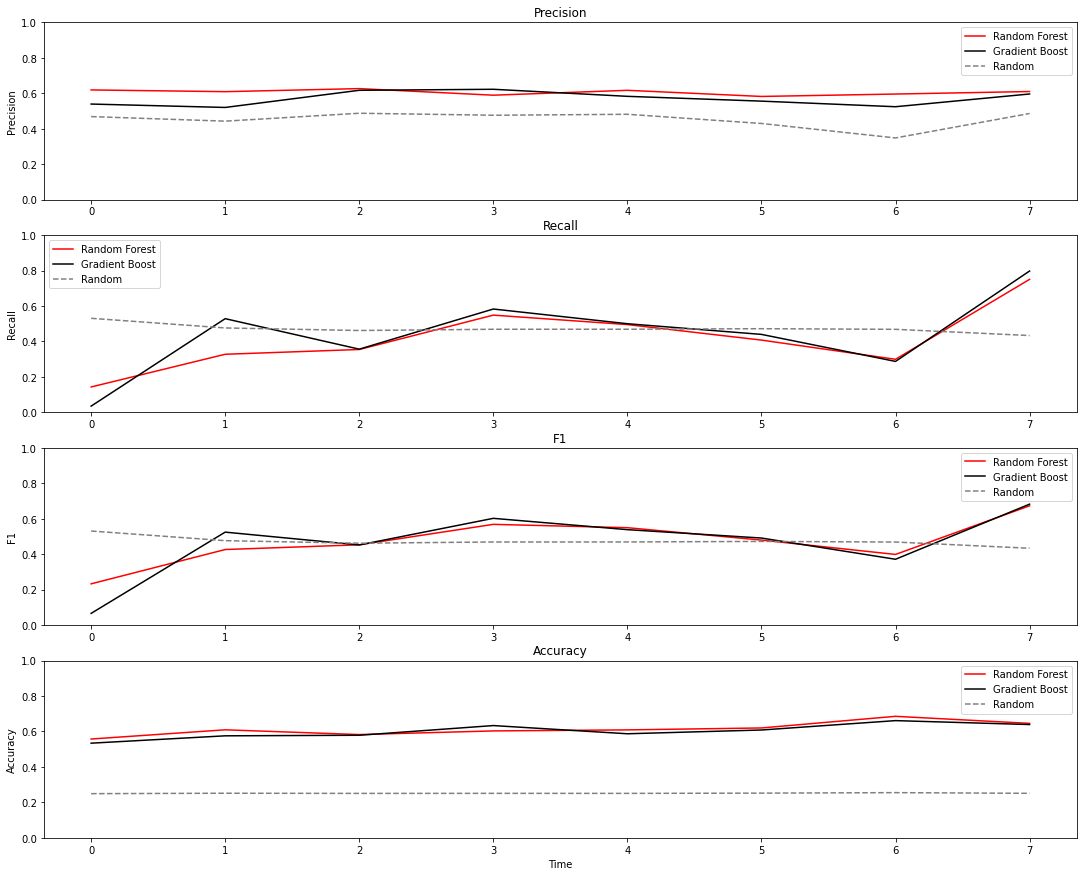

In [32]:
fig, axs = plt.subplots(4,1)
fig.set_size_inches(18.5, 15)

# Create the  plot
axs[0].plot(range(len(Precision_Test_RF)), Precision_Test_RF, color = 'r',label = 'Random Forest')
axs[0].plot(range(len(Precision_Test_Boost)), Precision_Test_Boost, color = 'black', label = 'Gradient Boost')
axs[0].plot(range(len(Test_Skew)), Test_Skew,color = 'grey', linestyle ='--',label = 'Random')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision')
# axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])

axs[1].plot(range(len(Recall_Test_RF)), Recall_Test_RF,color = 'r',label = 'Random Forest')
axs[1].plot(range(len(Recall_Test_Boost)), Recall_Test_Boost, color = 'black', label = 'Gradient Boost')
axs[1].plot(range(len(Train_Skew)), Train_Skew,color = 'grey', linestyle ='--', label = 'Random')
axs[1].set_ylabel('Recall')
axs[1].set_title('Recall')
axs[1].set_ylim([0,1])

axs[2].plot(range(len(Recall_Test_RF)), 2*Precision_Test_RF*Recall_Test_RF/(Precision_Test_RF+Recall_Test_RF),color = 'r',label = 'Random Forest')
axs[2].plot(range(len(Recall_Test_Boost)), 2*Precision_Test_Boost*Recall_Test_Boost/(Precision_Test_Boost+Recall_Test_Boost), color = 'black', label = 'Gradient Boost')
axs[2].plot(range(len(Train_Skew)), Train_Skew,color = 'grey', linestyle ='--', label = 'Random')
axs[2].set_ylabel('F1')
axs[2].set_title('F1')
axs[2].set_ylim([0,1])

axs[3].plot(range(len(Accuracy_Test_RF)), Accuracy_Test_RF,color = 'r',label = 'Random Forest')
axs[3].plot(range(len(Accuracy_Test_Boost)), Accuracy_Test_Boost,color = 'black', label = 'Gradient Boost')
axs[3].plot(range(len(Train_Skew)), Train_Skew*Test_Skew + 0.5*(1-Train_Skew-Test_Skew),color = 'grey', linestyle ='--', label = 'Random')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Accuracy')
axs[3].set_title('Accuracy')
axs[3].set_ylim([0,1])

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper right')
axs[3].legend(loc='upper right')

5.4 Run some stresses to determine optimal Model parameters

In [ ]:
Train = np.empty(0)
Test = np.empty(0)
# Depth_plot = [20,40,50,70,80,100,120,150, 200, 250]
Depth_plot = np.empty(0)

for Depth in range(2,30,1):
# for Depth in range(10,300,10):    
#     Model = RandomForestClassifier(max_depth = 10, random_state=4021, n_estimators = Depth)
    Model = RandomForestClassifier(max_depth = Depth, random_state=4021, n_estimators = 50)
    Model.fit(TrainX, TrainY)

    Train_Error =np.sum(Model.predict(TrainX) == TrainY)/len(TrainY)
    Train = np.append(Train, Train_Error)
    
    Test_Error = np.sum(Model.predict(TestX) == TestY)/len(TestY)
    Test = np.append(Test, Test_Error)
    
    Depth_plot = np.append(Depth_plot, Depth)
    
    print(Depth," : ", Train_Error, " : ", Test_Error)

print("")
Keep_Track()  

5.5 Plot the results

In [ ]:
fig, axs = plt.subplots(2,1)
fig.set_size_inches(18.5, 10)

# Create the  plot
axs[0].scatter(Depth_plot, Train, s=10)

# axs[0].scatter(Depth_plot, Test, color = 'r', s= 10)
axs[0].set_xlabel('Trees')
axs[0].set_ylabel('Acc')
axs[0].set_title('Train')
# axs[0].set_xlim([0,100])
# axs[0].set_ylim([0,1])

# Create the  plot
# axs[1].scatter(Depth_plot, Train, s=10)

axs[1].scatter(Depth_plot, Test, color = 'r', s= 10)
# axs[1].scatter(Depth_plot, Test_2, color = 'r', s= 10)
axs[1].set_xlabel('Trees')
axs[1].set_ylabel('Acc')
axs[1].set_title('Train')


plt.show()

#### 6 Backtest

In [53]:
# Choose some data to use for study/training/backtesting
Start = '2021-06-01'
Mid = '2021-10-01'

# Choose the testing set
End = '2021-11-01'

# Train the model
Train, TrainX, TrainY, Test, TestX, TestY = Train_Test_Build(Coins_Modelling, Coin, Forecast_Field, Start,  Mid, End)

Train_Skew = np.append(Train_Skew, np.sum(TrainY)/len(TrainY))
Test_Skew = np.append(Test_Skew, np.sum(TestY)/len(TestY))
    
print("* Training RF Model")
Estimators = 60
Model_RF = RandomForestClassifier(max_depth= 6, random_state=4021, n_estimators = Estimators)
Model_RF.fit(TrainX, TrainY)

print('* Generating forecasts')
ForecastsY = Model_RF.predict(TestX)

Prob = Model_RF.predict_proba(TestX)

print('')
Keep_Track() 

* Train / Test split with ~
         - Forecast field: Cap_Return%
         - Coin          : BTC
         -               : Cap_Return%_BTC
         - Training      : 2021-06-01 -> 2021-10-01
         - Testing       : 2021-10-01 -> 2021-11-01

* Test Length   : 44459
* Train Length  : 174566
* X shape       : (174566, 28)
* Y shape       : (174566,)
Train Skew      :  0.5306474342082651
Test Skew       :  0.4686115297240154
* Training RF Model
* Generating forecasts

Executed successfully. Tue 05 Jul @ 15:10:45



In [52]:
TestX


array([[ 4.35323100e+04,  4.33331200e+04,  4.38257300e+04, ...,
        -1.99026541e-01,  6.41935683e-01,  6.91808292e-01],
       [ 4.36363400e+04,  4.33694800e+04,  4.38803800e+04, ...,
        -4.83821704e-04,  6.25996271e-01,  6.89068545e-01],
       [ 4.36216100e+04,  4.33716000e+04,  4.39800000e+04, ...,
         2.74316587e+00,  6.66809744e-01,  7.02027676e-01],
       ...,
       [ 6.06495200e+04,  6.07191800e+04,  6.09225200e+04, ...,
        -1.36002351e-01,  4.26643482e-01,  4.27629261e-01],
       [ 6.06608700e+04,  6.06572500e+04,  6.09150200e+04, ...,
        -1.66912674e+00,  4.24292061e-01,  4.26248150e-01],
       [ 6.06994200e+04,  6.06401800e+04,  6.09270400e+04, ...,
        -2.39007289e-01,  4.21917817e-01,  4.25952160e-01]])

In [54]:
# Create a dataset to run the backtesting
Backtest_Data = Sample_Data(Core_Data, 'DateTime', UpperDate = End, LowerDate = Mid)
Backtest_Data['Prob_Start'] = Prob[:,1]

Backtest_Data['DateTime'] = pd.to_datetime(Backtest_Data['DateTime'], dayfirst=True)
Backtest_Data['End_Date'] = pd.to_datetime(Backtest_Data['End_Date'], dayfirst=True)

# Example
Start_Date = '2021-10-31 00:05:00'
Backtest_Data[Backtest_Data['DateTime']==Start_Date][['DateTime','End_Date','Life(s)','Initial_Open','Final_Close', 'Level', 'Capital','Cap_Return%', 'Prob_Start']]

,DateTime,End_Date,Life(s),Initial_Open,Final_Close,Level,Capital,Cap_Return%,Prob_Start
478765,2021-10-31 00:05:00,2021-10-31 03:05:00,10800.0,62090.18,61815.2,1,2.78,-0.005375,0.356364


In [57]:
# Calculate the indicators - these are times when the model thinks the start date is good.
# Choose a probability threshold
Threshold = 0.6

# Calculate the corresponding times when the algo would start.
Indicator = Backtest_Data['Prob_Start'] > Threshold

print('* Threshold set to     :', Threshold)
print('* Dates in data        :', len(Backtest_Data))
print('* % start dates        :', np.sum(Indicator)/len(Indicator))

print('')
Keep_Track() 

* Threshold set to     : 0.6
* Dates in data        : 44459
* % start dates        : 0.047616905463460715

Executed successfully. Tue 05 Jul @ 15:12:15



In [58]:
#Create some copies 
Run_Start = Backtest_Data[Indicator][['DateTime','End_Date','Level','Life(s)','Cap_Return%']].copy()
Run_End = Backtest_Data[Indicator][['DateTime','End_Date','Level','Life(s)','Cap_Return%']].copy()

# Add one minute to the end date to force the next algo to start at the next time (rather than immediately)
Run_Start['End_Date'] = Run_Start['End_Date'] + pd.offsets.DateOffset(minutes=1)
Run_End['End_Date'] = Run_End['End_Date'] + pd.offsets.DateOffset(minutes=1)

# Include additional measures if calculated
# Run_Start = Out_All[Indicator][['Start_Date','End_Date','Level','Life(s)','Cap_Return%','Sharpe','Max_Drawdown']].copy()
# Run_End = Out_All[Indicator][['Start_Date','End_Date','Level','Life(s)','Cap_Return%','Sharpe','Max_Drawdown']].copy()

# Add in a distant date to terminate the process later
End_Record = Run_Start[Run_Start['DateTime']==np.max(Run_Start['DateTime'])].copy()
End_Record['DateTime'] = End_Record['DateTime'] + pd.offsets.DateOffset(years=20)
End_Record['End_Date'] = End_Record['DateTime']

# For this new date we have no results of interest.  Set to Nan so they can be excluded
End_Record['Cap_Return%'] = np.nan
End_Record['Level'] = np.nan
End_Record['Life(s)'] = np.nan
# End_Record['Sharpe'] = np.nan
# End_Record['Max_Drawdown'] = np.nan

# Add the records in
Run_Start = pd.concat([Run_Start,End_Record])
Run_End = pd.concat([Run_End,End_Record])

# Order Run_start by start date and Run_End by end date so we can use merge_asof
Run_Start = Run_Start.sort_values(by=['End_Date'])
Run_End = Run_End.sort_values(by=['DateTime'])


print('')
Keep_Track()


Executed successfully. Tue 05 Jul @ 15:12:17



Build the paths.  Each algo runs until it stops.  We then wait until the next start date allowed (for example the next date an indicator is true) then it runs again.  etc.

In [37]:
def Build_Paths(Run_Start, Run_End):

    print('* Running ...')
    # Loop over joins until all data used.
    Continue = True

    # only need a limited number - 400 should be enough (the number of algos)
    for i in range(400):

        if Continue:
            print(i,'|',end='')

            if i == 0:
                left_name = 'End_Date'
            else:
                left_name = 'End_Date_' + str(i-1)

            suffix_name = '_'+str(i)
            sort_name = 'End_Date_' +str(i)

            Run_Start = pd.merge_asof(Run_Start, Run_End, left_on=left_name, right_on = 'DateTime', suffixes=('', suffix_name), direction='forward').sort_values(by=[sort_name])

            # Loop until all end dates are the last date.
            Continue = ~(Run_Start[left_name] == np.array(End_Record['DateTime'])[0]).all()
            
    return Run_Start      

print('* Build non-overlapping paths function complete')
print('')
Keep_Track()

* Build non-overlapping paths function complete

Executed successfully. Tue 05 Jul @ 14:49:05



Run

In [59]:
Results = Build_Paths(Run_Start, Run_End)
print('')
print('')
Keep_Track()

* Running ...
0 |1 |2 |3 |4 |5 |6 |7 |8 |9 |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |24 |25 |26 |27 |28 |29 |30 |31 |32 |33 |34 |35 |36 |37 |38 |39 |40 |41 |42 |43 |44 |45 |46 |47 |48 |49 |50 |51 |52 |53 |54 |55 |56 |57 |58 |59 |60 |61 |62 |63 |64 |65 |66 |67 |68 |69 |70 |71 |72 |73 |74 |75 |76 |77 |78 |79 |80 |81 |82 |83 |84 |85 |86 |87 |88 |

Executed successfully. Tue 05 Jul @ 15:12:23



In [39]:
(Results.loc[:,Results.columns.str.startswith("DateTime")]).head(5)

,DateTime,DateTime_0,DateTime_1,DateTime_2,DateTime_3,DateTime_4,DateTime_5,DateTime_6,DateTime_7,DateTime_8,...,DateTime_89,DateTime_90,DateTime_91,DateTime_92,DateTime_93,DateTime_94,DateTime_95,DateTime_96,DateTime_97,DateTime_98
0,2021-10-01 10:28:00,2021-10-01 10:29:00,2021-10-01 10:30:00,2021-10-01 10:31:00,2021-10-01 10:32:00,2021-10-01 10:33:00,2021-10-01 10:42:00,2021-10-01 10:43:00,2021-10-01 10:44:00,2021-10-01 11:52:00,...,2021-10-28 18:46:00,2021-10-28 18:50:00,2021-10-28 18:52:00,2021-10-28 19:48:00,2021-10-28 19:50:00,2021-10-28 19:59:00,2021-10-28 20:53:00,2021-10-30 14:36:00,2041-10-30 14:46:00,2041-10-30 14:46:00
1939,2021-10-01 11:20:00,2021-10-01 11:52:00,2021-10-01 14:43:00,2021-10-03 21:07:00,2021-10-04 14:55:00,2021-10-04 16:00:00,2021-10-04 16:19:00,2021-10-04 16:20:00,2021-10-04 17:38:00,2021-10-04 17:53:00,...,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00
1940,2021-10-01 11:29:00,2021-10-01 11:52:00,2021-10-01 14:43:00,2021-10-03 21:07:00,2021-10-04 14:55:00,2021-10-04 16:00:00,2021-10-04 16:19:00,2021-10-04 16:20:00,2021-10-04 17:38:00,2021-10-04 17:53:00,...,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00
1941,2021-10-01 11:21:00,2021-10-01 11:52:00,2021-10-01 14:43:00,2021-10-03 21:07:00,2021-10-04 14:55:00,2021-10-04 16:00:00,2021-10-04 16:19:00,2021-10-04 16:20:00,2021-10-04 17:38:00,2021-10-04 17:53:00,...,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00
1942,2021-10-01 11:05:00,2021-10-01 11:52:00,2021-10-01 14:43:00,2021-10-03 21:07:00,2021-10-04 14:55:00,2021-10-04 16:00:00,2021-10-04 16:19:00,2021-10-04 16:20:00,2021-10-04 17:38:00,2021-10-04 17:53:00,...,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00,2041-10-30 14:46:00


In [ ]:
# (Results.loc[:,Results.columns.str.startswith("DateTime")]).head(5)

In [61]:
Start_Date = '2021-10-01 10:28:00'
Backtest_Data[Backtest_Data['DateTime']==Start_Date][['DateTime','End_Date','Life(s)','Initial_Open','Final_Close', 'Level', 'Capital','Cap_Return%', 'Prob_Start']]

,DateTime,End_Date,Life(s),Initial_Open,Final_Close,Level,Capital,Cap_Return%,Prob_Start
436188,2021-10-01 10:28:00,2021-10-01 10:28:00,0.0,45703.6,46750.0,0,1.39,0.031825,0.63575


In [62]:
# Example Cap return
(Results.loc[:,Results.columns.str.startswith("Cap_Return%")]).head(5)

,Cap_Return%,Cap_Return%_0,Cap_Return%_1,Cap_Return%_2,Cap_Return%_3,Cap_Return%_4,Cap_Return%_5,Cap_Return%_6,Cap_Return%_7,Cap_Return%_8,...,Cap_Return%_79,Cap_Return%_80,Cap_Return%_81,Cap_Return%_82,Cap_Return%_83,Cap_Return%_84,Cap_Return%_85,Cap_Return%_86,Cap_Return%_87,Cap_Return%_88
0,0.031825,0.020592,0.011659,0.008389,0.013572,0.031100,0.015465,0.011783,0.027770,0.009552,...,0.015577,0.016320,0.010203,0.009288,0.008666,0.009431,0.016274,-0.149717,NaN,NaN
1420,0.011560,0.030250,0.008433,0.039166,0.022283,0.030988,0.036003,0.008620,0.030332,0.029548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1419,0.009098,0.009552,-0.013412,0.027771,0.009569,0.009163,0.010292,0.008919,0.014798,0.030250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1418,0.011659,0.008389,0.013572,0.031100,0.015465,0.011783,0.027770,0.009552,-0.013412,0.027771,...,0.010203,0.009288,0.008666,0.009431,0.016274,-0.149717,NaN,NaN,NaN,NaN
1417,0.027770,0.009552,-0.013412,0.027771,0.009569,0.009163,0.010292,0.008919,0.014798,0.030250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Summary Statistics

In [63]:
print('Cap Return Run Mean :',round(((Results.loc[:,Results.columns.str.startswith("Cap_Return%")]).mean(axis = 1).mean()),3))
print('Level Run Mean      :',round(((Results.loc[:,Results.columns.str.startswith("Level")]).mean(axis = 1).mean()),3))
print('Run time Mean (min) :',round(((Results.loc[:,Results.columns.str.startswith("Life(s)")]).mean(axis = 1).mean()/60),2))

# print('Sharpe Mean         :',round(((Results.loc[:,Results.columns.str.startswith("Sharpe")]).mean(axis = 1).mean()), 4))
# print('Drawdown            :',round(((Results.loc[:,Results.columns.str.startswith("Max_Drawdown")]).min(axis = 1).mean()), 4))

Cap Return Run Mean : 0.009
Level Run Mean      : 1.305
Run time Mean (min) : 57.7
